<a href="https://colab.research.google.com/github/gyq1985/deepmindset/blob/main/model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
data_path = "/content/drive/Shareddrives/Deepmindset/dataset/clean_dataset/images"

Mounted at /content/drive


In [2]:
import os
import shutil
import random

def split_dataset_into_train_val_test(original_dir, output_dir, train_ratio=0.7, val_ratio=0.10, test_ratio=0.20, seed=42):
    random.seed(seed)

    classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

    for class_name in classes:
        class_dir = os.path.join(original_dir, class_name)
        images = os.listdir(class_dir)
        images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src = os.path.join(class_dir, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

    print("数据集划分完成！")

original_data_dir = "/content/drive/Shareddrives/Deepmindset/dataset/clean_dataset/images"
output_data_dir = "/content/drive/Shareddrives/Deepmindset/dataset/split_dataset"
split_dataset_into_train_val_test(original_data_dir, output_data_dir)


ConnectionAbortedError: [Errno 103] Software caused connection abort

# Start From There

## data loader

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# Set dataset path
data_path = "/content/drive/Shareddrives/Deepmindset/dataset/split_dataset"
train_dir = data_path + "/train"
val_dir = data_path + "/val"
test_dir = data_path + "/test"


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 增强只用于训练集
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 840 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


## model 1

In [6]:
# Build lightweight CNN with higher dropout
from tensorflow.keras import layers, models, Input

model = models.Sequential([
    Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Increased dropout
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [7]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)
# Compile model
model.compile(
    optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model with EarlyStopping
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 304s 11s/step - accuracy: 0.2691 - loss: 5.3628 - val_accuracy: 0.2917 - val_loss: 1.3754
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.3538 - loss: 1.3703 - val_accuracy: 0.4417 - val_loss: 1.2609
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.4295 - loss: 1.2505 - val_accuracy: 0.5667 - val_loss: 1.0319
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.5547 - loss: 1.1274 - val_accuracy: 0.6083 - val_loss: 0.9957
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.4999 - loss: 1.1501 - val_accuracy: 0.6083 - val_loss: 0.9445
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5172 - loss: 1.0946 - val_accuracy: 0.5917 - val_loss: 0.8753
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.5710 - loss: 1.0266 - val_accuracy: 0.5667 - val_loss: 0.8809
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.5683 - loss: 1.0170 - val_accuracy: 0.6333 - val_l

In [9]:
loss, acc = model.evaluate(test_generator)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5415 - loss: 1.0365
Test loss: 0.8396
Test accuracy: 0.6583


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 764ms/step - accuracy: 0.5415 - loss: 1.0365


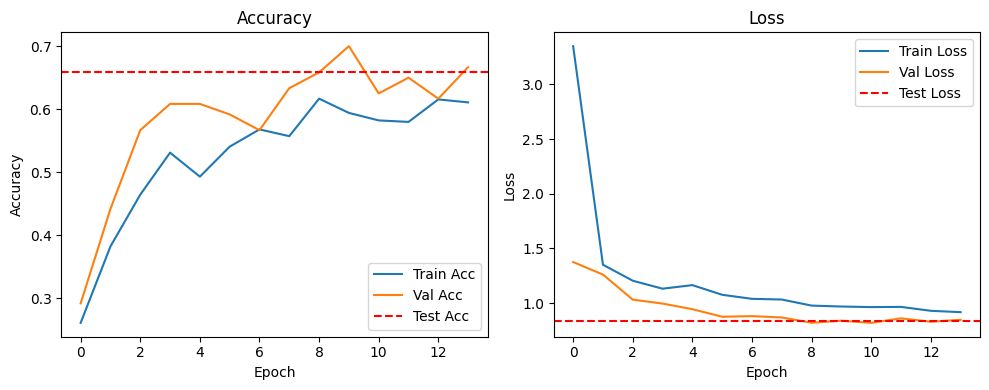

In [11]:
import matplotlib.pyplot as plt

# 评估
test_loss, test_acc = model.evaluate(test_generator)

# 图像绘制
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


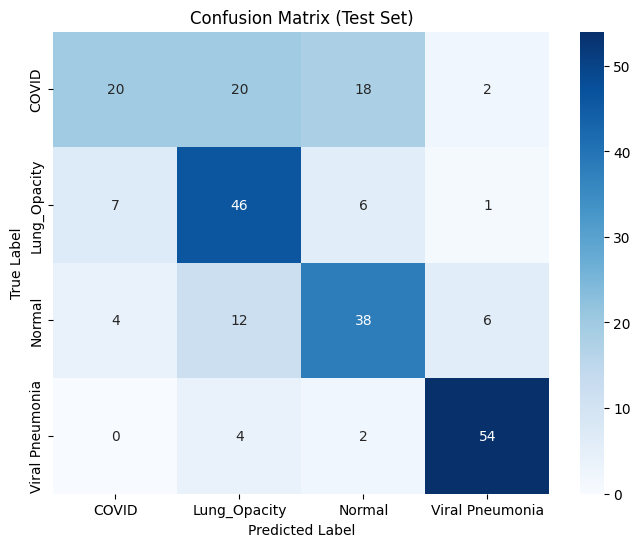

Classification Report (Test Set):

                 precision    recall  f1-score   support

          COVID       0.65      0.33      0.44        60
   Lung_Opacity       0.56      0.77      0.65        60
         Normal       0.59      0.63      0.61        60
Viral Pneumonia       0.86      0.90      0.88        60

       accuracy                           0.66       240
      macro avg       0.66      0.66      0.64       240
   weighted avg       0.66      0.66      0.64       240



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 重置生成器（防止之前的迭代影响）
test_generator.reset()

# 真实标签
Y_true = test_generator.classes

# 预测标签
Y_pred = np.argmax(model.predict(test_generator), axis=1)

# 类别名称
labels = list(test_generator.class_indices.keys())

# 混淆矩阵
cm = confusion_matrix(Y_true, Y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 分类报告
print("Classification Report (Test Set):\n")
print(classification_report(Y_true, Y_pred, target_names=labels))
